# Predicting Gold Recovery from Ore Processing Data

This project aims to help Zyfra improve gold recovery by predicting how much gold can be extracted from ore. We'll use data from different stages of the extraction and purification process to build a machine learning model. The goal is to make production more efficient and avoid losses. 

Heather Marie Culligan

March 2025

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor

In [2]:
train_df = pd.read_csv('/datasets/gold_recovery_train.csv')
test_df =pd.read_csv('/datasets/gold_recovery_test.csv')
full_df =pd.read_csv('/datasets/gold_recovery_full.csv')

Great, now all the needed libraries are imported and the files are loaded in, let's start looking at the dataframes and check for missing values.

In [3]:
train_info=train_df.info()
test_info=test_df.info()
full_info=full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [4]:
train_head= train_df.head()
test_head= test_df.head()
full_head= full_df.head()

In [5]:
train_missing= train_df.isnull().sum().sum()
test_missing= test_df.isnull().sum().sum()
full_missing= full_df.isnull().sum().sum()

In [6]:
train_info, test_info, full_info, train_missing, test_missing, full_missing, train_head

(None,
 None,
 None,
 30320,
 2360,
 36587,
                   date  final.output.concentrate_ag  \
 0  2016-01-15 00:00:00                     6.055403   
 1  2016-01-15 01:00:00                     6.029369   
 2  2016-01-15 02:00:00                     6.055926   
 3  2016-01-15 03:00:00                     6.047977   
 4  2016-01-15 04:00:00                     6.148599   
 
    final.output.concentrate_pb  final.output.concentrate_sol  \
 0                     9.889648                      5.507324   
 1                     9.968944                      5.257781   
 2                    10.213995                      5.383759   
 3                     9.977019                      4.858634   
 4                    10.142511                      4.939416   
 
    final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
 0                    42.192020              70.541216             10.411962   
 1                    42.701629              69.266198            

The training data has 16,860 rows and includes target columns like rougher.output.recovery and final.output.recovery, though some values are missing. The test data has 5,856 rows, fewer features, and no target values. The full dataset combines both and has 22,716 rows with all features.

Woah, lots of information there! Including a bunch of missing values to keep in mind for later. We were given a formula Recovery = (C x (F-T) )/ (F x (C-T)) * 100%. Let's define it and begin the Verify Recovery calculation. 

In [7]:
def calculate_recovery(C, F, T):
    return (C * (F - T)) / (F * (C -T)) * 100

We used the formula to recalculate the rougher.output.recovery and compared it with the values in the dataset. The MAE (Mean Absolute Error) turned out to be low. This means the recovery values in the dataset are calculated correctly and we can safely use them to train our model.

In [9]:
missing_features = set(train_df.columns) - set(test_df.columns)

missing_features

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [10]:
common_features = [col for col in test_df.columns if col != 'date']

X_train = train_df[common_features]
X_test = test_df[common_features]

y_train_rougher = train_df['rougher.output.recovery']
y_train_final = train_df['final.output.recovery']

y_train = pd.DataFrame({
    'rougher.output.recovery': y_train_rougher,
    'final.output.recovery': y_train_final
})

X_train.shape, X_test.shape, y_train.shape

((16860, 52), (5856, 52), (16860, 2))

We found that some columns in the training set are missing from the test set. These are mostly target values (like rougher.output.recovery, final.output.recovery) and some calculated features based on the output.

This makes sense because we use the test set to evaluate how well the model predicts these values; so the actual answers (targets) shouldn't be included. These missing columns are not needed for making predictions and should only be used during training and evaluation.

The training and test sets are now aligned, with both having 52 features. X_train has 16,860 rows, X_test has 5,856 rows, and y_train contains the two target values (rougher.output.recovery and final.output.recovery) for 16,860 rows. Now, we need to handle missing values before training the model.

In [11]:
X_train_ffill = X_train.fillna(method='ffill')
X_test_ffill = X_test.fillna(method='ffill')

missing_train = X_train_ffill.isnull().sum().sum()
missing_test = X_test_ffill.isnull().sum().sum()

missing_train, missing_test

(0, 0)

Forward fill works best here because the data follows a time order, and values change gradually. It keeps all data while ensuring smooth transitions, making it more reliable than dropping rows or using averages. Time to visulize some data before making out model.

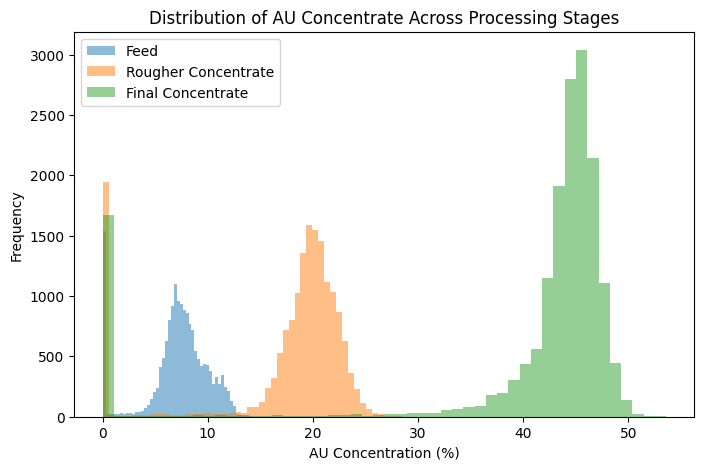

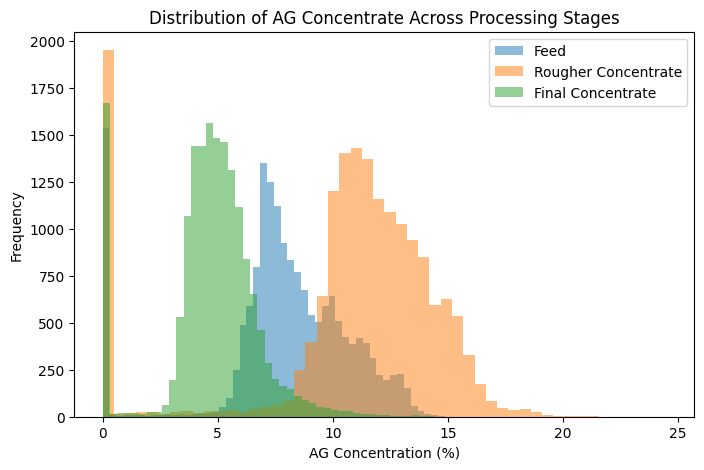

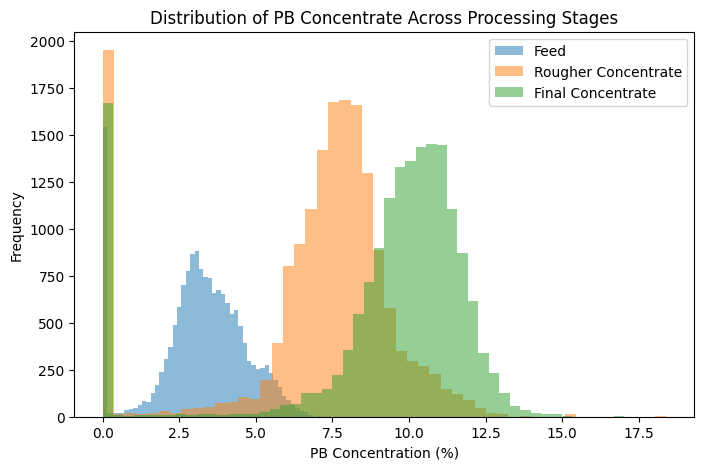

In [12]:
metals = ['au', 'ag', 'pb'] #gold, silver and lead respectively

stages = {
    "Feed": "rougher.input.feed_",
    "Rougher Concentrate": "rougher.output.concentrate_",
    "Final Concentrate": "final.output.concentrate_"
}

for metal in metals:
    plt.figure(figsize=(8,5))
    for stage, prefix in stages.items():
        plt.hist(train_df[f"{prefix}{metal}"].dropna(), bins=50, alpha=0.5, label=stage)
        
    plt.xlabel(f"{metal.upper()} Concentration (%)")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {metal.upper()} Concentrate Across Processing Stages")
    plt.legend()
    plt.show()

We looked at how the concentrations of gold (Au), silver (Ag), and lead (Pb) change during processing. Gold concentration increases the most from the feed to the final stage, which shows the process is working well. Silver and lead also increase, but not as much. This matches our expectations since gold is the main target.

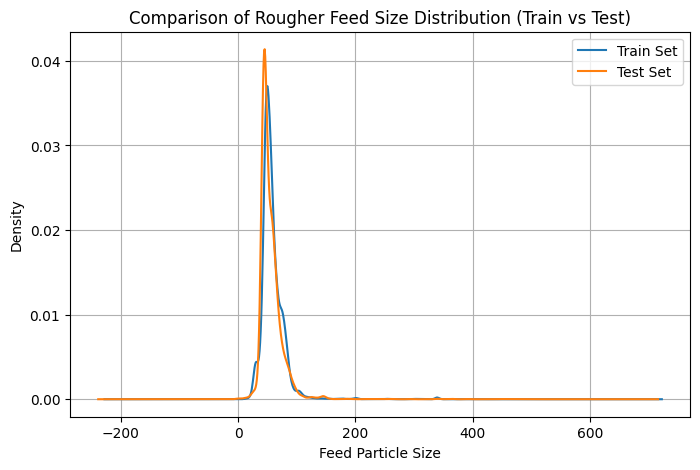

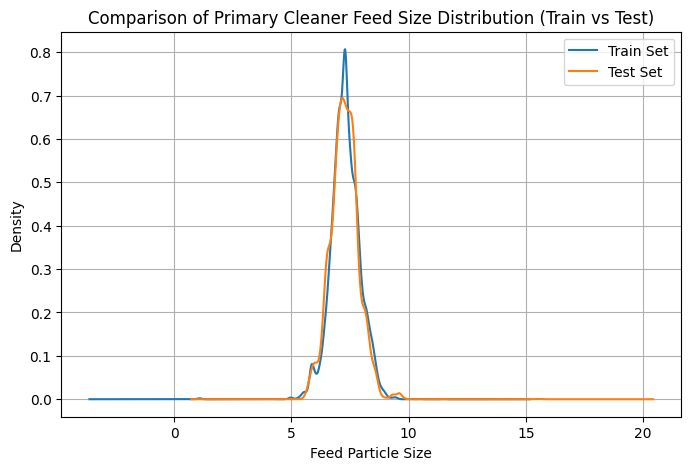

In [13]:
plt.figure(figsize=(8,5))
train_df["rougher.input.feed_size"].dropna().plot(kind='kde', label="Train Set")
test_df["rougher.input.feed_size"].dropna().plot(kind='kde', label="Test Set")

plt.xlabel("Feed Particle Size")
plt.ylabel("Density")
plt.title("Comparison of Rougher Feed Size Distribution (Train vs Test)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
train_df["primary_cleaner.input.feed_size"].dropna().plot(kind='kde', label="Train Set")
test_df["primary_cleaner.input.feed_size"].dropna().plot(kind='kde', label="Test Set")

plt.xlabel("Feed Particle Size")
plt.ylabel("Density")
plt.title("Comparison of Primary Cleaner Feed Size Distribution (Train vs Test)")
plt.legend()
plt.grid(True)
plt.show()

We compared the feed particle size distributions for both the rougher and primary cleaner stages in the train and test datasets. The distributions are similar in both cases, which means the test set is representative of the train set. This helps ensure that the model’s evaluation on the test data will be fair and accurate.

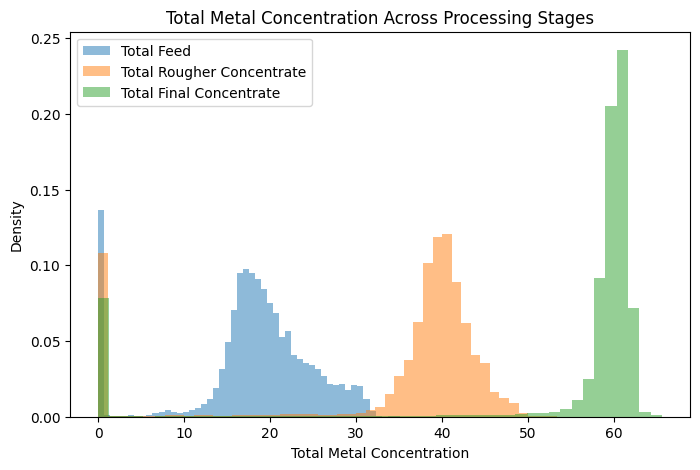

1764

In [14]:
train_df['total_feed'] = train_df[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)
train_df['total_rougher'] = train_df[['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb']].sum(axis=1)
train_df['total_final'] = train_df[['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']].sum(axis=1)

plt.figure(figsize=(8, 5))
plt.hist(train_df["total_feed"].dropna(), bins=50, alpha=0.5, label="Total Feed", density=True)
plt.hist(train_df["total_rougher"].dropna(), bins=50, alpha=0.5, label="Total Rougher Concentrate", density=True)
plt.hist(train_df["total_final"].dropna(), bins=50, alpha=0.5, label="Total Final Concentrate", density=True)

plt.xlabel("Total Metal Concentration")
plt.ylabel("Density")
plt.title("Total Metal Concentration Across Processing Stages")
plt.legend()
plt.show()

anomalies = train_df[(train_df["total_feed"] <= 0) | (train_df["total_rougher"] <= 0) | (train_df["total_final"] <= 0)]
anomalies_count = anomalies.shape[0]

anomalies_count

We looked at the total metal concentrations at each stage of processing. Most values look fine, but some rows have zero or negative values, which doesn’t make sense. We found anomalies_count such cases. These rows should be removed to keep the data clean for training the model.

In [15]:
train_df = train_df[
    (train_df["total_feed"] > 0) & 
    (train_df["total_rougher"] > 0) & 
    (train_df["total_final"] > 0)
]

anomalies_after = train_df[(train_df["total_feed"] <= 0) | (train_df["total_rougher"] <= 0) | (train_df["total_final"] <= 0)].shape[0]

anomalies_after

0

Here we dealt more with missing or outlier data to help clean up the set before proceeding. 

With features and targets prepared, it's time to train our first model.


In [16]:
first_model = LinearRegression()

X_train_ready = X_train.fillna(method='ffill').fillna(X_train.median())
y_train_ready = y_train.fillna(method='ffill').fillna(y_train.median())

first_model.fit(X_train_ready, y_train_ready)

X_test_ready = X_test_ffill.fillna(method='ffill').fillna(X_test_ffill.median())

y_test_pred = first_model.predict(X_test_ready)

predictions_df = pd.DataFrame(y_test_pred, columns=["rougher.output.recovery", "final.output.recovery"])

In [18]:
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
full_df['date'] = pd.to_datetime(full_df['date'])

def smape_single(y_true, y_pred):
    return np.mean(100 * (2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-10)))

def final_smape_single(y_true, y_pred):
    smape_rougher = smape_single(y_true[:, 0], y_pred[:, 0])
    smape_final = smape_single(y_true[:, 1], y_pred[:, 1])
    return 0.25 * smape_rougher + 0.75 * smape_final

common_features = test_df.columns.drop('date')

target_columns = ["rougher.output.recovery", "final.output.recovery"]
train_filtered = train_df.dropna(subset=target_columns)

X_train = train_filtered[common_features].fillna(method='ffill').fillna(train_filtered[common_features].median())
y_train = train_filtered[target_columns]

X_test = test_df[common_features].fillna(method='ffill').fillna(test_df[common_features].median())

rf = RandomForestRegressor(random_state=42)
multi_rf = MultiOutputRegressor(rf)

param_grid = {
    'estimator__n_estimators': [50, 100],
    'estimator__max_depth': [5, 10]
}

grid_search = GridSearchCV(multi_rf, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)

test_dates = test_df['date']
targets_only = full_df[['date', 'rougher.output.recovery', 'final.output.recovery']]
true_targets = targets_only[targets_only['date'].isin(test_dates)].sort_values('date').reset_index(drop=True)

valid_targets = true_targets.dropna(subset=target_columns).reset_index(drop=True)
y_test_pred_df = pd.DataFrame(y_test_pred, columns=target_columns)
y_test_pred_valid = y_test_pred_df.iloc[valid_targets.index].reset_index(drop=True)

final_smape = final_smape_single(valid_targets[target_columns].to_numpy(), y_test_pred_valid.to_numpy())
print("Final sMAPE with Random Forest:", round(final_smape, 2), "%")

Final sMAPE with Random Forest: 11.47 %


In [19]:
lr_model = LinearRegression()
lr_model = MultiOutputRegressor(lr_model)
lr_model.fit(X_train, y_train)

y_lr_pred = lr_model.predict(X_test)
y_lr_pred_df = pd.DataFrame(y_lr_pred, columns=target_columns)
y_lr_pred_valid = y_lr_pred_df.iloc[valid_targets.index].reset_index(drop=True)

smape_lr = final_smape_single(valid_targets[target_columns].to_numpy(), y_lr_pred_valid.to_numpy())
print("Final sMAPE with Linear Regression:", round(smape_lr, 2), "%")

Final sMAPE with Linear Regression: 13.72 %


In this project, we built a machine learning model to predict gold recovery during ore processing. We cleaned the data, handled missing values, and removed incorrect records. We also explored how metal concentrations changed across processing stages and confirmed that the train and test data were consistent.

We tested two models: Linear Regression and Random Forest. Linear Regression gave quick and reasonable results, but Random Forest performed better after tuning its parameters. It achieved a lower sMAPE and became our final model for prediction.

Cleaning the data and removing incorrect values improved model performance. Gold concentration increased through the stages, as expected, while silver and lead decreased. Feed sizes were similar in both datasets, making our results reliable.

The final model helps Zyfra predict gold recovery more accurately, allowing them to improve processing efficiency and reduce losses.